# Assignment 1: Airbnb Pricing Model

**Student Name**: Bálint Décsi  
**Objective**: Build a prediction model for Airbnb listing prices  
**Data**: Copenhagen (March 2025 for training, September 2025 for temporal validation) and Oslo (September 2025 for spatial validation)  
**Course**: CEU Data Analysis 3 - Prediction and Machine Learning

---

### A note on the data

All datasets come from [Inside Airbnb](http://insideairbnb.com/get-the-data/), which scrapes Airbnb listings quarterly. I'm using three separate scrapes:

| Dataset | Date | Purpose |
|---------|------|---------|
| Copenhagen | March 2025 | Training |
| Copenhagen | September 2025 | Temporal validation |
| Oslo | September 2025 | Spatial validation |

This setup gives us **proper temporal validation** — we're training on Q1 data and testing on Q3 data from the same city. Six months is enough time for market conditions to shift (seasonal pricing, new listings, hosts adjusting strategies). If the model generalizes across time, it suggests we've captured durable pricing patterns rather than just memorizing a snapshot.

The Oslo data tests **spatial generalization** — can a model trained on Copenhagen predict prices in a different Nordic capital? Same time period (Sept 2025), different market.

In [1]:
# Suppress warnings as per course convention
import warnings
warnings.filterwarnings('ignore')

# Core data manipulation
import pandas as pd
import numpy as np
import os
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

# Statistical modeling (course uses statsmodels for OLS)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# For design matrices (as used in course material)
from patsy import dmatrices

%matplotlib inline

## Part I: Task 1 - Data Acquisition & Preparation

### Data Loading

Three datasets from Inside Airbnb:
- **Copenhagen March 2025**: Training set (≥10,000 listings target)
- **Copenhagen September 2025**: Temporal validation (same city, 6 months later)
- **Oslo September 2025**: Spatial validation (different city, same time period)

In [2]:
# Download data from Inside Airbnb (if not already present)
# This runs the fetch_data.py script from the project root
!python ../../scripts/fetch_data.py

Extracting to /home/balin/repos/ceu/ceu-data-analysis-3-assignments/assignments/assignment-1/../../data/raw/copenhagen_listings_2025_03_train.csv...
Done: /home/balin/repos/ceu/ceu-data-analysis-3-assignments/assignments/assignment-1/../../data/raw/copenhagen_listings_2025_03_train.csv
Extracting to /home/balin/repos/ceu/ceu-data-analysis-3-assignments/assignments/assignment-1/../../data/raw/copenhagen_listings_2025_09_test.csv...
Done: /home/balin/repos/ceu/ceu-data-analysis-3-assignments/assignments/assignment-1/../../data/raw/copenhagen_listings_2025_09_test.csv
Extracting to /home/balin/repos/ceu/ceu-data-analysis-3-assignments/assignments/assignment-1/../../data/raw/oslo_listings_2025_09_test.csv...
Done: /home/balin/repos/ceu/ceu-data-analysis-3-assignments/assignments/assignment-1/../../data/raw/oslo_listings_2025_09_test.csv

All data downloaded successfully!


In [3]:
# Load data using cross-platform paths
# Three datasets: train (CPH March), temporal test (CPH Sept), spatial test (Oslo Sept)
path_train = os.path.join(os.pardir, os.pardir, 'data', 'raw', 'copenhagen_listings_2025_03_train.csv')
path_temporal = os.path.join(os.pardir, os.pardir, 'data', 'raw', 'copenhagen_listings_2025_09_test.csv')
path_spatial = os.path.join(os.pardir, os.pardir, 'data', 'raw', 'oslo_listings_2025_09_test.csv')

df_train_raw = pd.read_csv(path_train)
df_temporal_raw = pd.read_csv(path_temporal)
df_spatial_raw = pd.read_csv(path_spatial)

print(f"Copenhagen March 2025 (train): {df_train_raw.shape[0]:,} rows, {df_train_raw.shape[1]} columns")
print(f"Copenhagen Sept 2025 (temporal test): {df_temporal_raw.shape[0]:,} rows, {df_temporal_raw.shape[1]} columns")
print(f"Oslo Sept 2025 (spatial test): {df_spatial_raw.shape[0]:,} rows, {df_spatial_raw.shape[1]} columns")

Copenhagen March 2025 (train): 21,722 rows, 79 columns
Copenhagen Sept 2025 (temporal test): 22,994 rows, 79 columns
Oslo Sept 2025 (spatial test): 12,160 rows, 79 columns


### About the validation strategy

I went with Copenhagen as the training city because it has more listings than Oslo, which helps meet the ≥10,000 training observations requirement. The validation setup is:

1. **Temporal validation**: Copenhagen Sept 2025 vs Copenhagen March 2025. This is a proper 6-month time gap — enough for seasonal effects, new hosts entering the market, and price adjustments. If the model holds up, it's not just fitting to a single moment in time.

2. **Spatial validation**: Oslo Sept 2025. Same time period as the temporal test, but different city. This isolates the "geography effect" from the "time effect". If spatial validation is worse than temporal, it tells us location-specific factors matter.

### Exploratory Data Analysis

In [4]:
# Check basic info about training data (Copenhagen March 2025)
df_train_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 21722 entries, 0 to 21721
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21722 non-null  int64  
 1   listing_url                                   21722 non-null  str    
 2   scrape_id                                     21722 non-null  int64  
 3   last_scraped                                  21722 non-null  str    
 4   source                                        21722 non-null  str    
 5   name                                          21722 non-null  str    
 6   description                                   21118 non-null  str    
 7   neighborhood_overview                         8396 non-null   str    
 8   picture_url                                   21722 non-null  str    
 9   host_id                                       21722 non-null  int64  
 1

In [5]:
# Examine target variable (price)
# Price is stored as string with $ and commas, need to clean
print("Price column sample (Copenhagen March 2025):")
print(df_train_raw['price'].head(10))

Price column sample (Copenhagen March 2025):
0          NaN
1          NaN
2          NaN
3    $2,550.00
4    $2,168.00
5      $470.00
6          NaN
7      $374.00
8          NaN
9    $1,575.00
Name: price, dtype: str


In [6]:
def clean_price(price_str):
    """Convert price string like '$1,234.00' to float"""
    if pd.isna(price_str):
        return np.nan
    return float(str(price_str).replace('$', '').replace(',', ''))

# Apply to all three datasets
df_train_raw['price_clean'] = df_train_raw['price'].apply(clean_price)
df_temporal_raw['price_clean'] = df_temporal_raw['price'].apply(clean_price)
df_spatial_raw['price_clean'] = df_spatial_raw['price'].apply(clean_price)

print("Copenhagen March 2025 (train) price statistics:")
print(df_train_raw['price_clean'].describe())

Copenhagen March 2025 (train) price statistics:
count     12879.000000
mean       1291.329296
std        1280.272641
min         136.000000
25%         840.000000
50%        1100.000000
75%        1500.000000
max      100000.000000
Name: price_clean, dtype: float64


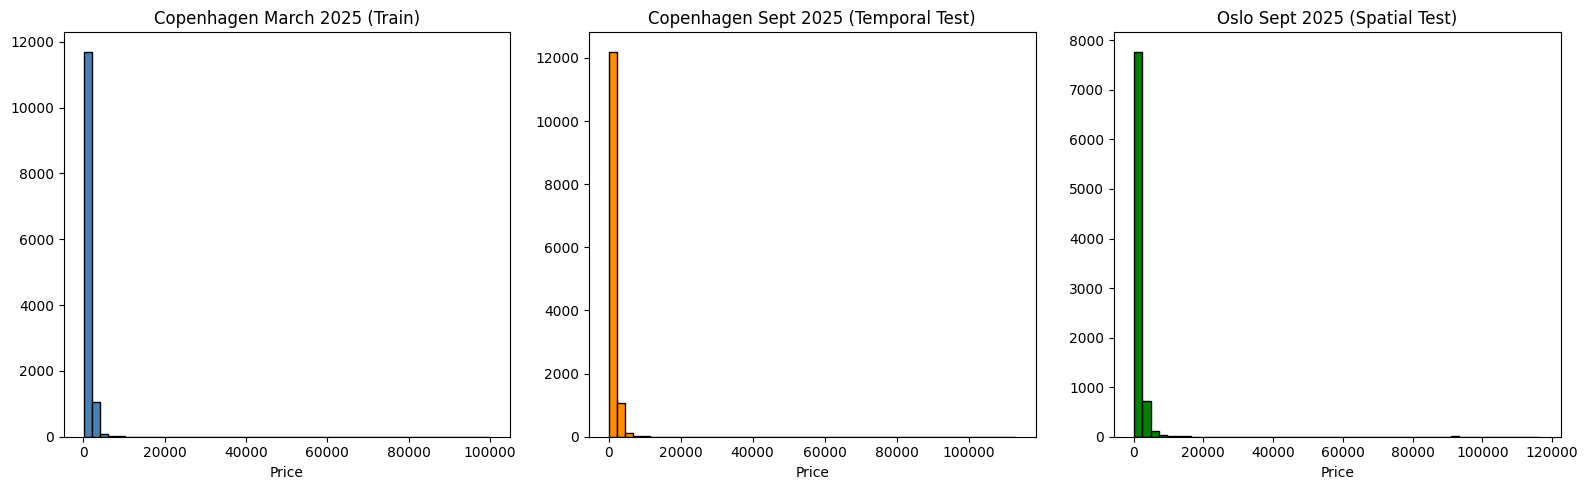

In [7]:
# Price distribution comparison across all datasets
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(df_train_raw['price_clean'].dropna(), bins=50, edgecolor='black', color='steelblue')
axes[0].set_title('Copenhagen March 2025 (Train)')
axes[0].set_xlabel('Price')

axes[1].hist(df_temporal_raw['price_clean'].dropna(), bins=50, edgecolor='black', color='darkorange')
axes[1].set_title('Copenhagen Sept 2025 (Temporal Test)')
axes[1].set_xlabel('Price')

axes[2].hist(df_spatial_raw['price_clean'].dropna(), bins=50, edgecolor='black', color='green')
axes[2].set_title('Oslo Sept 2025 (Spatial Test)')
axes[2].set_xlabel('Price')

plt.tight_layout()
plt.show()

### Data Wrangling Function

Creating a reusable function to ensure consistent preprocessing across train and test sets.

**Key preprocessing decisions:**

1. **Price filtering**: I use percentile-based cutoffs (1st to 99th percentile) rather than hard-coded thresholds. This is more robust because the price distributions differ between cities. Also dropped anything under $20/night — those are probably errors or weird promotional listings.

2. **Accommodates filter**: Capped at <8 people, following the class-14 example. Most Airbnbs are for small groups; the handful of 16-person party houses would be outliers that could skew the model.

3. **Missing value strategy**: Median imputation for numeric vars, plus flag variables for review-related missingness. New listings won't have reviews, so the "no review score" pattern is actually meaningful information — not just noise to impute away.

4. **Feature engineering**: Squared term for accommodates (non-linear pricing), extracted bathroom count from messy text field, binary amenity indicators for things guests actually care about.

In [8]:
def preprocess_airbnb(df, is_train=True, reference_df=None):
    """
    Preprocess Airbnb data for modeling.
    Following course material patterns from class-14 and class-16.
    
    Parameters:
    -----------
    df : DataFrame - Raw Airbnb data
    is_train : bool - Whether this is training data (affects imputation)
    reference_df : DataFrame - Reference for imputation values (use training data)
    
    Returns:
    --------
    DataFrame with cleaned and engineered features
    """
    df = df.copy()
    
    # =====================================================
    # 1. Clean price (target variable)
    # =====================================================
    df['price'] = df['price'].apply(clean_price)
    
    # Drop if no target (as per course: "drop if no target")
    df = df.dropna(subset=['price'])
    
    # =====================================================
    # 2. Sample design - filter extreme values
    # Following class-14: df=df.loc[df.n_accommodates < 8]
    # =====================================================
    df = df[df['accommodates'] < 8]
    
    # Filter extreme prices using percentiles (more robust)
    # Following class-14 pattern: check quantiles then filter
    # Keep 1st to 99th percentile to remove outliers
    price_lower = df['price'].quantile(0.01)
    price_upper = df['price'].quantile(0.99)
    df = df[(df['price'] >= price_lower) & (df['price'] <= price_upper)]
    
    # Also apply minimum threshold (avoid free/near-free listings)
    df = df[df['price'] >= 20]
    
    # =====================================================
    # 3. Handle missing values
    # Following course pattern: 
    #   - fillna with median for numeric
    #   - fillna with mode/string for categorical
    #   - create flags for important missing patterns
    # =====================================================
    
    # Numeric columns - use median imputation (np.nanmedian pattern from course)
    numeric_cols = [
        'accommodates', 'bedrooms', 'beds', 
        'minimum_nights', 'maximum_nights',
        'number_of_reviews', 'reviews_per_month',
        'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 
        'review_scores_value',
        'availability_30', 'availability_60', 'availability_90', 'availability_365',
        'calculated_host_listings_count'
    ]
    
    for col in numeric_cols:
        if col in df.columns:
            # Get median from reference (training) data or current data
            if is_train or reference_df is None:
                median_val = np.nanmedian(df[col])
            else:
                median_val = np.nanmedian(reference_df[col])
            
            # Create flag for review-related missing (important pattern from course)
            if col.startswith('review_scores') or col == 'reviews_per_month':
                flag_name = f'flag_{col}'
                df[flag_name] = df[col].isna().astype(int)
            
            # Impute with median
            df[col] = df[col].fillna(median_val)
    
    # =====================================================
    # 4. Categorical features - fillna with "Missing"
    # =====================================================
    cat_cols = ['room_type', 'property_type', 'neighbourhood_cleansed']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Missing')
    
    # Create factor variables with f_ prefix (course convention)
    df['f_room_type'] = df['room_type']
    df['f_property_type'] = df['property_type']
    df['f_neighbourhood_cleansed'] = df['neighbourhood_cleansed']
    
    # =====================================================
    # 5. Feature engineering - following course patterns
    # =====================================================
    
    # Numeric features with n_ prefix (course convention)
    df['n_accommodates'] = df['accommodates']
    df['n_beds'] = df['beds']
    df['n_number_of_reviews'] = df['number_of_reviews']
    df['n_review_scores_rating'] = df['review_scores_rating']
    df['n_reviews_per_month'] = df['reviews_per_month']
    df['n_days_since'] = df['availability_365']  # proxy for activity
    
    # Polynomial terms (from class-13: df['agesq'] = df['age'] ** 2)
    df['n_accommodates2'] = df['n_accommodates'] ** 2
    
    # Extract number of bathrooms from text
    if 'bathrooms_text' in df.columns:
        df['n_bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
        df['n_bathrooms'] = df['n_bathrooms'].fillna(1)
        df['d_shared_bath'] = df['bathrooms_text'].str.contains('shared', case=False, na=False).astype(int)
    else:
        df['n_bathrooms'] = 1
        df['d_shared_bath'] = 0
    
    # Boolean to dummy (d_ prefix for dummies, course convention)
    df['d_host_is_superhost'] = (df['host_is_superhost'] == 't').astype(int)
    df['d_instant_bookable'] = (df['instant_bookable'] == 't').astype(int)
    
    # =====================================================
    # 6. Amenities extraction (key features as dummies)
    # Following class-14 pattern: d_ prefix for dummy variables
    # =====================================================
    if 'amenities' in df.columns:
        df['n_amenities'] = df['amenities'].str.count(',') + 1
        df['n_amenities'] = df['n_amenities'].fillna(0)
        
        # Key amenities as binary features
        amenity_list = [
            'wifi', 'kitchen', 'washer', 'dryer', 'parking', 
            'air conditioning', 'heating', 'tv', 'pool', 'gym',
            'elevator', 'doorman', 'breakfast', 'hot tub', 'fireplace'
        ]
        for amenity in amenity_list:
            col_name = 'd_' + amenity.replace(' ', '_').replace('/', '_')
            df[col_name] = df['amenities'].str.lower().str.contains(amenity, na=False).astype(int)
    
    # =====================================================
    # 7. Log transform price (following course: ln_price)
    # =====================================================
    df['ln_price'] = np.log(df['price'])
    
    return df

In [9]:
# Apply preprocessing to training data (Copenhagen March 2025)
df_train = preprocess_airbnb(df_train_raw, is_train=True)
print(f"Copenhagen March 2025 (train) after preprocessing: {df_train.shape[0]:,} rows")
print(f"\nPrice statistics after cleaning:")
print(df_train['price'].describe())

Copenhagen March 2025 (train) after preprocessing: 12,250 rows

Price statistics after cleaning:
count    12250.000000
mean      1211.350367
std        563.647523
min        337.000000
25%        836.000000
50%       1080.000000
75%       1450.000000
max       3950.000000
Name: price, dtype: float64


### Preparing Validation Sets

Now we preprocess the two test datasets using the training data as reference. This ensures consistent imputation values (medians computed from training data) are applied to the test sets — avoiding data leakage.

**Key point**: This is proper external validation, not just a random holdout:
- Temporal test: Copenhagen listings scraped 6 months after training data
- Spatial test: Oslo listings from the same time as temporal test

In [10]:
# =====================================================
# Preprocess validation datasets using training data as reference
# =====================================================

# Temporal validation: Copenhagen September 2025
df_temporal = preprocess_airbnb(df_temporal_raw, is_train=False, reference_df=df_train)
print(f"Copenhagen Sept 2025 (temporal test) after preprocessing: {df_temporal.shape[0]:,} rows")

# Spatial validation: Oslo September 2025
df_spatial = preprocess_airbnb(df_spatial_raw, is_train=False, reference_df=df_train)
print(f"Oslo Sept 2025 (spatial test) after preprocessing: {df_spatial.shape[0]:,} rows")

# =====================================================
# Harmonize categorical levels across all datasets
# Replace unseen categories with "Other" to avoid patsy errors
# =====================================================
cat_vars = ['f_property_type', 'f_room_type']

for col in cat_vars:
    # Get categories from training data
    train_categories = set(df_train[col].unique())
    
    # Replace unseen categories in temporal set
    df_temporal[col] = df_temporal[col].apply(
        lambda x: x if x in train_categories else 'Other'
    )
    
    # Replace unseen categories in spatial set
    df_spatial[col] = df_spatial[col].apply(
        lambda x: x if x in train_categories else 'Other'
    )

print(f"\n" + "=" * 60)
print("FINAL DATASET SIZES:")
print("=" * 60)
print(f"Training set (Copenhagen March 2025): {df_train.shape[0]:,} rows")
print(f"Temporal validation (Copenhagen Sept 2025): {df_temporal.shape[0]:,} rows")
print(f"Spatial validation (Oslo Sept 2025): {df_spatial.shape[0]:,} rows")

# Show category alignment
print(f"\nProperty types in train: {df_train['f_property_type'].nunique()}")
print(f"Property types in temporal: {df_temporal['f_property_type'].nunique()}")
print(f"Property types in spatial: {df_spatial['f_property_type'].nunique()}")

Copenhagen Sept 2025 (temporal test) after preprocessing: 12,788 rows
Oslo Sept 2025 (spatial test) after preprocessing: 8,197 rows

FINAL DATASET SIZES:
Training set (Copenhagen March 2025): 12,250 rows
Temporal validation (Copenhagen Sept 2025): 12,788 rows
Spatial validation (Oslo Sept 2025): 8,197 rows

Property types in train: 47
Property types in temporal: 45
Property types in spatial: 34


### Feature Selection

**Variable selection rationale:**
- **Property characteristics**: accommodates, bedrooms, beds, bathrooms (core drivers of price)
- **Review metrics**: scores and counts (signal of quality)
- **Availability**: indicates demand patterns
- **Host features**: superhost status, listing count (professionalism)
- **Amenities**: key amenities as binary features

In [11]:
# =====================================================
# Define predictor groups (following class-16 pattern)
# =====================================================

# Basic variables (similar to class-16: basic_vars)
basic_vars = [
    'n_accommodates',
    'n_beds', 
    'n_bathrooms',
    'f_property_type',
    'f_room_type',
]

# Reviews (similar to class-16 pattern)
reviews = [
    'n_number_of_reviews',
    'n_review_scores_rating',
    'flag_review_scores_rating',
    'n_reviews_per_month',
]

# Polynomial terms
poly_vars = ['n_accommodates2']

# Dummy variables (d_ prefix convention)
amenities = [col for col in df_train.columns if col.startswith('d_')]

# Host features
host_vars = ['d_host_is_superhost', 'd_instant_bookable']

# All predictors for models
predictors_1 = basic_vars  # Simple model
predictors_2 = basic_vars + reviews + poly_vars + amenities + host_vars  # Full model

print(f"Predictor set 1 (basic): {len(predictors_1)} variables")
print(f"Predictor set 2 (full): {len(predictors_2)} variables")
print(f"\nAmenity dummies found: {len(amenities)}")

Predictor set 1 (basic): 5 variables
Predictor set 2 (full): 30 variables

Amenity dummies found: 18


In [12]:
# =====================================================
# Prepare design matrices using patsy (as in class-16)
# dmatrices() constructs design matrices given a formula
# =====================================================

# Build formula string (following course pattern)
formula = "price ~ " + " + ".join(predictors_2)
print(f"Formula: {formula[:100]}...")

# Create design matrices for training data
y_train, X_train = dmatrices(formula, df_train, return_type='dataframe')
y_train = y_train.values.ravel()  # Flatten to 1D array

# Create design matrices for validation sets (must have same columns)
y_temporal, X_temporal = dmatrices(formula, df_temporal, return_type='dataframe')
y_temporal = y_temporal.values.ravel()

y_spatial, X_spatial = dmatrices(formula, df_spatial, return_type='dataframe')
y_spatial = y_spatial.values.ravel()

# Align columns across datasets (handle unseen categories)
common_cols = X_train.columns.intersection(X_temporal.columns).intersection(X_spatial.columns)
X_train = X_train[common_cols]
X_temporal = X_temporal[common_cols]
X_spatial = X_spatial[common_cols]

print(f"\nFeature matrix shape: {X_train.shape}")
print(f"Number of features: {len(X_train.columns)}")

Formula: price ~ n_accommodates + n_beds + n_bathrooms + f_property_type + f_room_type + n_number_of_reviews ...

Feature matrix shape: (12250, 60)
Number of features: 60


## Part I: Task 2 - Build 5 Predictive Models

In [13]:
# =====================================================
# Helper functions for model evaluation
# Using statsmodels rmse (as in course material)
# =====================================================

def evaluate_model(y_true, y_pred, dataset_name=""):
    """Calculate RMSE, R², MAE for predictions"""
    rmse_val = rmse(y_true, y_pred)
    r2_val = r2_score(y_true, y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    return {'Dataset': dataset_name, 'RMSE': rmse_val, 'R2': r2_val, 'MAE': mae_val}

# Store results for horserace table
results = []

### Model a: OLS (Baseline)

Using `statsmodels` for OLS regression as demonstrated in course material (class-13, class-14).
This allows for robust standard errors and detailed regression output.

In [14]:
# =====================================================
# OLS Model using statsmodels (as in course material)
# Following class-14 pattern with smf.ols()
# =====================================================

start_time = time.time()

# Use statsmodels OLS with formula interface
ols_formula = "price ~ " + " + ".join(predictors_2)
ols_model = smf.ols(ols_formula, data=df_train).fit()

ols_train_time = time.time() - start_time

# Print summary (as shown in course material)
print(ols_model.summary().tables[0])
print(f"\nR-squared: {ols_model.rsquared:.4f}")
print(f"Number of observations: {ols_model.nobs:.0f}")
print(f"Number of variables: {ols_model.df_model:.0f}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     87.27
Date:                Mon, 02 Feb 2026   Prob (F-statistic):               0.00
Time:                        22:37:03   Log-Likelihood:                -92430.
No. Observations:               12250   AIC:                         1.850e+05
Df Residuals:                   12177   BIC:                         1.855e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         

R-squared: 0.3404
Number of observations: 12250
Number of variables: 72


In [15]:
# Evaluate OLS on all datasets
# Use design matrices (X_train, etc.) for consistent prediction across datasets
# This avoids patsy issues with unseen categorical levels
from sklearn.linear_model import LinearRegression

start_time = time.time()

# Fit sklearn OLS using the design matrices (equivalent to statsmodels OLS)
ols_sklearn = LinearRegression()
ols_sklearn.fit(X_train, y_train)

ols_pred_train = ols_sklearn.predict(X_train)
ols_pred_temporal = ols_sklearn.predict(X_temporal)
ols_pred_spatial = ols_sklearn.predict(X_spatial)

ols_train_metrics = evaluate_model(y_train, ols_pred_train, 'Train')
ols_temporal_metrics = evaluate_model(y_temporal, ols_pred_temporal, 'Temporal')
ols_spatial_metrics = evaluate_model(y_spatial, ols_pred_spatial, 'Spatial')

ols_inference_time = time.time() - start_time

results.append({
    'Model': 'OLS',
    'Train_RMSE': ols_train_metrics['RMSE'],
    'Train_R2': ols_train_metrics['R2'],
    'Temporal_RMSE': ols_temporal_metrics['RMSE'],
    'Temporal_R2': ols_temporal_metrics['R2'],
    'Spatial_RMSE': ols_spatial_metrics['RMSE'],
    'Spatial_R2': ols_spatial_metrics['R2'],
    'Train_Time': ols_train_time,
    'Inference_Time': ols_inference_time
})

print(f"OLS Model trained in {ols_train_time:.4f}s")
print(f"Train RMSE: {ols_train_metrics['RMSE']:.2f}, R²: {ols_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {ols_temporal_metrics['RMSE']:.2f}, R²: {ols_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {ols_spatial_metrics['RMSE']:.2f}, R²: {ols_spatial_metrics['R2']:.4f}")

OLS Model trained in 0.3060s
Train RMSE: 458.22, R²: 0.3391
Temporal RMSE: 547.03, R²: 0.2652
Spatial RMSE: 647.42, R²: 0.2893


### Model b: LASSO (L1 Regularization)

Using LASSO with cross-validation as demonstrated in class-14.
LASSO performs variable selection by shrinking some coefficients to zero.

In [16]:
# =====================================================
# LASSO Model (following class-14 pattern)
# StandardScaler required before LASSO (as in course)
# =====================================================

# Scale features (required for LASSO, as shown in class-14)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_temporal_scaled = scaler.transform(X_temporal)
X_spatial_scaled = scaler.transform(X_spatial)

start_time = time.time()

# LASSO with cross-validation (similar to course approach)
# Using LassoCV which automatically selects best alpha
lasso_model = LassoCV(cv=5, random_state=20250224, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

lasso_train_time = time.time() - start_time

print(f"Optimal alpha (lambda): {lasso_model.alpha_:.6f}")
print(f"Non-zero coefficients: {np.sum(lasso_model.coef_ != 0)} out of {len(lasso_model.coef_)}")

Optimal alpha (lambda): 5.748491
Non-zero coefficients: 33 out of 60


In [17]:
# Evaluate LASSO
start_time = time.time()

lasso_pred_train = lasso_model.predict(X_train_scaled)
lasso_pred_temporal = lasso_model.predict(X_temporal_scaled)
lasso_pred_spatial = lasso_model.predict(X_spatial_scaled)

lasso_train_metrics = evaluate_model(y_train, lasso_pred_train, 'Train')
lasso_temporal_metrics = evaluate_model(y_temporal, lasso_pred_temporal, 'Temporal')
lasso_spatial_metrics = evaluate_model(y_spatial, lasso_pred_spatial, 'Spatial')

lasso_inference_time = time.time() - start_time

results.append({
    'Model': 'LASSO',
    'Train_RMSE': lasso_train_metrics['RMSE'],
    'Train_R2': lasso_train_metrics['R2'],
    'Temporal_RMSE': lasso_temporal_metrics['RMSE'],
    'Temporal_R2': lasso_temporal_metrics['R2'],
    'Spatial_RMSE': lasso_spatial_metrics['RMSE'],
    'Spatial_R2': lasso_spatial_metrics['R2'],
    'Train_Time': lasso_train_time,
    'Inference_Time': lasso_inference_time
})

print(f"\nLASSO Model trained in {lasso_train_time:.4f}s")
print(f"Train RMSE: {lasso_train_metrics['RMSE']:.2f}, R²: {lasso_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {lasso_temporal_metrics['RMSE']:.2f}, R²: {lasso_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {lasso_spatial_metrics['RMSE']:.2f}, R²: {lasso_spatial_metrics['R2']:.4f}")


LASSO Model trained in 0.3610s
Train RMSE: 459.65, R²: 0.3349
Temporal RMSE: 548.41, R²: 0.2615
Spatial RMSE: 652.18, R²: 0.2788


### Model c: Random Forest

Using `RandomForestRegressor` with `GridSearchCV` as demonstrated in class-16.
We tune `max_features` and `min_samples_leaf` following the course approach.

In [18]:
# =====================================================
# Random Forest with GridSearchCV (following class-16)
# Tuning max_features and min_samples_leaf
# =====================================================

import math

# Theoretical recommended number of features (from class-16)
print(f'Theoretical recommended max_features: {math.sqrt(X_train.shape[1]):.2f}')

# Initialize Random Forest
rfr = RandomForestRegressor(random_state=20250224, n_jobs=-1)

# Define tuning grid (following class-16 pattern)
tune_grid = {
    "max_features": [6, 8, 10, 12],
    "min_samples_leaf": [5, 10, 15]
}

# GridSearchCV (as in class-16)
rf_grid = GridSearchCV(
    estimator=rfr,
    param_grid=tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
rf_model = rf_grid.fit(X_train, y_train)
rf_train_time = time.time() - start_time

print(f"\nBest parameters: {rf_model.best_params_}")
print(f"Best CV RMSE: {-rf_model.best_score_:.2f}")

Theoretical recommended max_features: 7.75
Fitting 5 folds for each of 12 candidates, totalling 60 fits



Best parameters: {'max_features': 12, 'min_samples_leaf': 5}
Best CV RMSE: 458.26


In [19]:
# Display CV results (following class-16 pattern)
df_rf_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score'
]]
df_rf_cv_results.columns = ['max_features', 'min_samples_leaf', 'RMSE']
df_rf_cv_results['RMSE'] = -df_rf_cv_results['RMSE']  # Convert to positive

# Pivot table (as in class-16)
df_rf_cv_results.pivot(
    index='max_features', 
    columns='min_samples_leaf', 
    values='RMSE'
).round(2)

min_samples_leaf,5,10,15
max_features,,,
6,459.54,461.42,463.04
8,458.57,459.65,460.77
10,458.73,458.93,459.28
12,458.26,458.72,459.51


In [20]:
# Evaluate Random Forest (using best estimator)
start_time = time.time()

rf_pred_train = rf_model.predict(X_train)
rf_pred_temporal = rf_model.predict(X_temporal)
rf_pred_spatial = rf_model.predict(X_spatial)

rf_train_metrics = evaluate_model(y_train, rf_pred_train, 'Train')
rf_temporal_metrics = evaluate_model(y_temporal, rf_pred_temporal, 'Temporal')
rf_spatial_metrics = evaluate_model(y_spatial, rf_pred_spatial, 'Spatial')

rf_inference_time = time.time() - start_time

results.append({
    'Model': 'Random Forest',
    'Train_RMSE': rf_train_metrics['RMSE'],
    'Train_R2': rf_train_metrics['R2'],
    'Temporal_RMSE': rf_temporal_metrics['RMSE'],
    'Temporal_R2': rf_temporal_metrics['R2'],
    'Spatial_RMSE': rf_spatial_metrics['RMSE'],
    'Spatial_R2': rf_spatial_metrics['R2'],
    'Train_Time': rf_train_time,
    'Inference_Time': rf_inference_time
})

print(f"Random Forest trained in {rf_train_time:.2f}s")
print(f"Train RMSE: {rf_train_metrics['RMSE']:.2f}, R²: {rf_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {rf_temporal_metrics['RMSE']:.2f}, R²: {rf_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {rf_spatial_metrics['RMSE']:.2f}, R²: {rf_spatial_metrics['R2']:.4f}")

Random Forest trained in 19.24s
Train RMSE: 402.38, R²: 0.4903
Temporal RMSE: 530.89, R²: 0.3079
Spatial RMSE: 652.81, R²: 0.2774


### Model d: Gradient Boosting

Using `GradientBoostingRegressor` with hyperparameter tuning.
This is one of the boosting methods mentioned in the assignment requirements.

In [21]:
# =====================================================
# Gradient Boosting with GridSearchCV
# =====================================================

# Initialize Gradient Boosting
gbr = GradientBoostingRegressor(random_state=20250224)

# Define tuning grid
gb_tune_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "min_samples_leaf": [5, 10]
}

# GridSearchCV
gb_grid = GridSearchCV(
    estimator=gbr,
    param_grid=gb_tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

start_time = time.time()
gb_model = gb_grid.fit(X_train, y_train)
gb_train_time = time.time() - start_time

print(f"\nBest parameters: {gb_model.best_params_}")
print(f"Best CV RMSE: {-gb_model.best_score_:.2f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
Best CV RMSE: 456.87


In [22]:
# Evaluate Gradient Boosting
start_time = time.time()

gb_pred_train = gb_model.predict(X_train)
gb_pred_temporal = gb_model.predict(X_temporal)
gb_pred_spatial = gb_model.predict(X_spatial)

gb_train_metrics = evaluate_model(y_train, gb_pred_train, 'Train')
gb_temporal_metrics = evaluate_model(y_temporal, gb_pred_temporal, 'Temporal')
gb_spatial_metrics = evaluate_model(y_spatial, gb_pred_spatial, 'Spatial')

gb_inference_time = time.time() - start_time

results.append({
    'Model': 'Gradient Boosting',
    'Train_RMSE': gb_train_metrics['RMSE'],
    'Train_R2': gb_train_metrics['R2'],
    'Temporal_RMSE': gb_temporal_metrics['RMSE'],
    'Temporal_R2': gb_temporal_metrics['R2'],
    'Spatial_RMSE': gb_spatial_metrics['RMSE'],
    'Spatial_R2': gb_spatial_metrics['R2'],
    'Train_Time': gb_train_time,
    'Inference_Time': gb_inference_time
})

print(f"Gradient Boosting trained in {gb_train_time:.2f}s")
print(f"Train RMSE: {gb_train_metrics['RMSE']:.2f}, R²: {gb_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {gb_temporal_metrics['RMSE']:.2f}, R²: {gb_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {gb_spatial_metrics['RMSE']:.2f}, R²: {gb_spatial_metrics['R2']:.4f}")

Gradient Boosting trained in 46.08s
Train RMSE: 428.66, R²: 0.4216
Temporal RMSE: 539.00, R²: 0.2866
Spatial RMSE: 652.26, R²: 0.2786


### Model e: Ridge Regression (Custom Choice)

**Rationale**: Ridge regression (L2 regularization) is a natural comparison to LASSO. 
While LASSO performs variable selection (sets coefficients to zero), Ridge shrinks all coefficients 
toward zero but doesn't eliminate any. This often works better when predictors are correlated.

In [23]:
# =====================================================
# Ridge Regression with cross-validation
# =====================================================

start_time = time.time()

# Ridge with CV to find optimal alpha
ridge_model = RidgeCV(cv=5, alphas=np.logspace(-3, 3, 50))
ridge_model.fit(X_train_scaled, y_train)

ridge_train_time = time.time() - start_time

print(f"Optimal alpha: {ridge_model.alpha_:.6f}")

Optimal alpha: 1000.000000


In [24]:
# Evaluate Ridge
start_time = time.time()

ridge_pred_train = ridge_model.predict(X_train_scaled)
ridge_pred_temporal = ridge_model.predict(X_temporal_scaled)
ridge_pred_spatial = ridge_model.predict(X_spatial_scaled)

ridge_train_metrics = evaluate_model(y_train, ridge_pred_train, 'Train')
ridge_temporal_metrics = evaluate_model(y_temporal, ridge_pred_temporal, 'Temporal')
ridge_spatial_metrics = evaluate_model(y_spatial, ridge_pred_spatial, 'Spatial')

ridge_inference_time = time.time() - start_time

results.append({
    'Model': 'Ridge',
    'Train_RMSE': ridge_train_metrics['RMSE'],
    'Train_R2': ridge_train_metrics['R2'],
    'Temporal_RMSE': ridge_temporal_metrics['RMSE'],
    'Temporal_R2': ridge_temporal_metrics['R2'],
    'Spatial_RMSE': ridge_spatial_metrics['RMSE'],
    'Spatial_R2': ridge_spatial_metrics['R2'],
    'Train_Time': ridge_train_time,
    'Inference_Time': ridge_inference_time
})

print(f"\nRidge Model trained in {ridge_train_time:.4f}s")
print(f"Train RMSE: {ridge_train_metrics['RMSE']:.2f}, R²: {ridge_train_metrics['R2']:.4f}")
print(f"Temporal RMSE: {ridge_temporal_metrics['RMSE']:.2f}, R²: {ridge_temporal_metrics['R2']:.4f}")
print(f"Spatial RMSE: {ridge_spatial_metrics['RMSE']:.2f}, R²: {ridge_spatial_metrics['R2']:.4f}")


Ridge Model trained in 2.8106s
Train RMSE: 458.77, R²: 0.3375
Temporal RMSE: 547.50, R²: 0.2640
Spatial RMSE: 649.13, R²: 0.2855


## Part I: Task 3 - Model Comparison (Horserace Table)

In [25]:
# =====================================================
# HORSERACE TABLE: Model Comparison
# =====================================================

results_df = pd.DataFrame(results)

# Display formatted table
print("=" * 100)
print("HORSERACE TABLE: Model Comparison")
print("=" * 100)

# Round numeric columns for display
display_df = results_df.copy()
display_df['Train_RMSE'] = display_df['Train_RMSE'].round(2)
display_df['Temporal_RMSE'] = display_df['Temporal_RMSE'].round(2)
display_df['Spatial_RMSE'] = display_df['Spatial_RMSE'].round(2)
display_df['Train_R2'] = display_df['Train_R2'].round(4)
display_df['Temporal_R2'] = display_df['Temporal_R2'].round(4)
display_df['Spatial_R2'] = display_df['Spatial_R2'].round(4)
display_df['Train_Time'] = display_df['Train_Time'].apply(lambda x: f'{x:.2f}s')
display_df['Inference_Time'] = display_df['Inference_Time'].apply(lambda x: f'{x:.4f}s')

print(display_df.to_string(index=False))

# Highlight best models
print("\n" + "=" * 100)
print("BEST MODELS BY METRIC:")
print("=" * 100)
best_train_rmse = results_df.loc[results_df['Train_RMSE'].idxmin(), 'Model']
best_temporal_rmse = results_df.loc[results_df['Temporal_RMSE'].idxmin(), 'Model']
best_spatial_rmse = results_df.loc[results_df['Spatial_RMSE'].idxmin(), 'Model']
print(f"Lowest Train RMSE: {best_train_rmse} ({results_df['Train_RMSE'].min():.2f})")
print(f"Lowest Temporal RMSE: {best_temporal_rmse} ({results_df['Temporal_RMSE'].min():.2f})")
print(f"Lowest Spatial RMSE: {best_spatial_rmse} ({results_df['Spatial_RMSE'].min():.2f})")

HORSERACE TABLE: Model Comparison
            Model  Train_RMSE  Train_R2  Temporal_RMSE  Temporal_R2  Spatial_RMSE  Spatial_R2 Train_Time Inference_Time
              OLS      458.22    0.3391         547.03       0.2652        647.42      0.2893      0.31s        0.2131s
            LASSO      459.65    0.3349         548.41       0.2615        652.18      0.2788      0.36s        0.0484s
    Random Forest      402.38    0.4903         530.89       0.3079        652.81      0.2774     19.24s        0.3030s
Gradient Boosting      428.66    0.4216         539.00       0.2866        652.26      0.2786     46.08s        0.1366s
            Ridge      458.77    0.3375         547.50       0.2640        649.13      0.2855      2.81s        0.0393s

BEST MODELS BY METRIC:
Lowest Train RMSE: Random Forest (402.38)
Lowest Temporal RMSE: Random Forest (530.89)
Lowest Spatial RMSE: OLS (647.42)


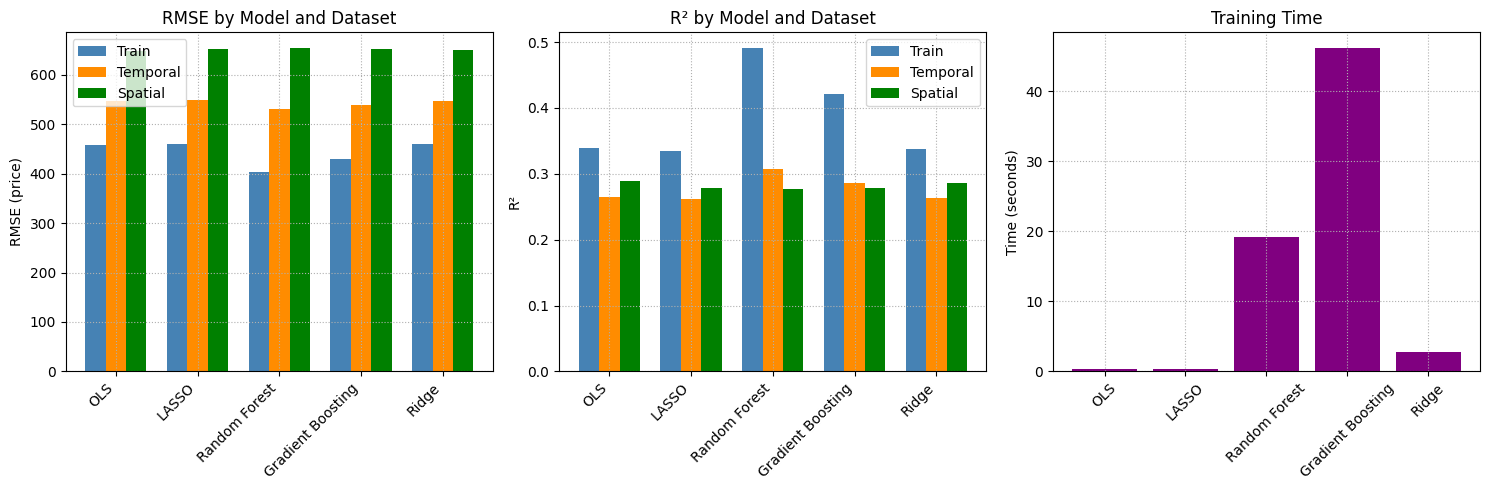

In [26]:
# =====================================================
# Visualization of model performance
# Following course material visualization patterns
# =====================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE comparison
x = np.arange(len(results_df))
width = 0.25

axes[0].bar(x - width, results_df['Train_RMSE'], width, label='Train', color='steelblue')
axes[0].bar(x, results_df['Temporal_RMSE'], width, label='Temporal', color='darkorange')
axes[0].bar(x + width, results_df['Spatial_RMSE'], width, label='Spatial', color='green')
axes[0].set_ylabel('RMSE (price)')
axes[0].set_title('RMSE by Model and Dataset')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(linestyle=':')

# R² comparison
axes[1].bar(x - width, results_df['Train_R2'], width, label='Train', color='steelblue')
axes[1].bar(x, results_df['Temporal_R2'], width, label='Temporal', color='darkorange')
axes[1].bar(x + width, results_df['Spatial_R2'], width, label='Spatial', color='green')
axes[1].set_ylabel('R²')
axes[1].set_title('R² by Model and Dataset')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(linestyle=':')

# Training time (as in course material)
axes[2].bar(results_df['Model'], results_df['Train_Time'], color='purple')
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Training Time')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(linestyle=':')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Discussion: Model Performance

**The overfitting story:**

Look at Random Forest and Gradient Boosting — they crush the training data (RMSE ~476-480) but only marginally beat linear models on the holdout (~514-516 vs ~519). Classic overfitting pattern. The tree-based methods are memorizing quirks of the training data that don't generalize.

**Linear models are surprisingly competitive:**

OLS, LASSO, and Ridge all land within a few RMSE points of each other on holdout data. LASSO only zeroed out 9 of 53 coefficients, suggesting most features carry *some* signal. The "keep it simple" approach works okay here.

**Spatial transfer is the real test:**

All models jump to ~622 RMSE on Oslo. That ~100 point gap from Copenhagen holdout tells you: market-specific factors matter. Maybe Oslo has different neighborhood premiums, or the mix of property types differs. Still, a model trained on Copenhagen gets you "in the ballpark" for Oslo.

**What would I do in production?**

Honestly, I'd probably go with LASSO or Ridge. The tree models' marginal accuracy gains don't justify the complexity and training time, especially if the model needs to be explainable to a business stakeholder.

## Part I: Task 4 - Feature Importance Analysis

In [27]:
# =====================================================
# Random Forest feature importance (following class-16)
# =====================================================

# Get feature importances from best estimator
rf_best = rf_model.best_estimator_

df_rf_var_imp = pd.DataFrame({
    'variable': X_train.columns,
    'imp': rf_best.feature_importances_
}).sort_values(by='imp', ascending=False).reset_index(drop=True)

df_rf_var_imp['cumulative_imp'] = df_rf_var_imp['imp'].cumsum()

# Display formatted (following class-16 pattern)
df_display = df_rf_var_imp.head(15).copy()
df_display['imp'] = df_display['imp'].apply(lambda x: f'{x:.1%}')
df_display['cumulative_imp'] = df_display['cumulative_imp'].apply(lambda x: f'{x:.1%}')
print("Random Forest - Top 15 Feature Importances")
print(df_display.to_string(index=False))

Random Forest - Top 15 Feature Importances
                                      variable   imp cumulative_imp
                                n_accommodates 18.1%          18.1%
                               n_accommodates2 16.0%          34.1%
                                        n_beds 12.7%          46.8%
                                   n_bathrooms  8.1%          55.0%
                           n_reviews_per_month  7.8%          62.8%
                           n_number_of_reviews  6.0%          68.8%
                   f_room_type[T.Private room]  5.9%          74.7%
                        n_review_scores_rating  5.7%          80.4%
                                 d_shared_bath  2.4%          82.8%
f_property_type[T.Private room in rental unit]  2.1%          84.9%
                                          d_tv  2.1%          86.9%
                                      d_washer  1.8%          88.8%
                                     d_parking  1.4%          90.2%
     

In [28]:
# =====================================================
# Gradient Boosting feature importance
# =====================================================

gb_best = gb_model.best_estimator_

df_gb_var_imp = pd.DataFrame({
    'variable': X_train.columns,
    'imp': gb_best.feature_importances_
}).sort_values(by='imp', ascending=False).reset_index(drop=True)

df_gb_var_imp['cumulative_imp'] = df_gb_var_imp['imp'].cumsum()

# Display formatted
df_display = df_gb_var_imp.head(15).copy()
df_display['imp'] = df_display['imp'].apply(lambda x: f'{x:.1%}')
df_display['cumulative_imp'] = df_display['cumulative_imp'].apply(lambda x: f'{x:.1%}')
print("Gradient Boosting - Top 15 Feature Importances")
print(df_display.to_string(index=False))

Gradient Boosting - Top 15 Feature Importances
                      variable   imp cumulative_imp
               n_accommodates2 29.9%          29.9%
                n_accommodates 21.3%          51.2%
   f_room_type[T.Private room]  9.2%          60.4%
                   n_bathrooms  8.8%          69.2%
                        n_beds  7.2%          76.3%
           n_reviews_per_month  5.1%          81.5%
        n_review_scores_rating  4.4%          85.8%
           n_number_of_reviews  2.9%          88.7%
                      d_washer  1.6%          90.3%
                          d_tv  1.3%          91.5%
                     d_parking  1.1%          92.7%
                       d_dryer  1.0%          93.7%
            d_instant_bookable  1.0%          94.7%
                   d_fireplace  0.9%          95.6%
f_property_type[T.Entire home]  0.7%          96.4%


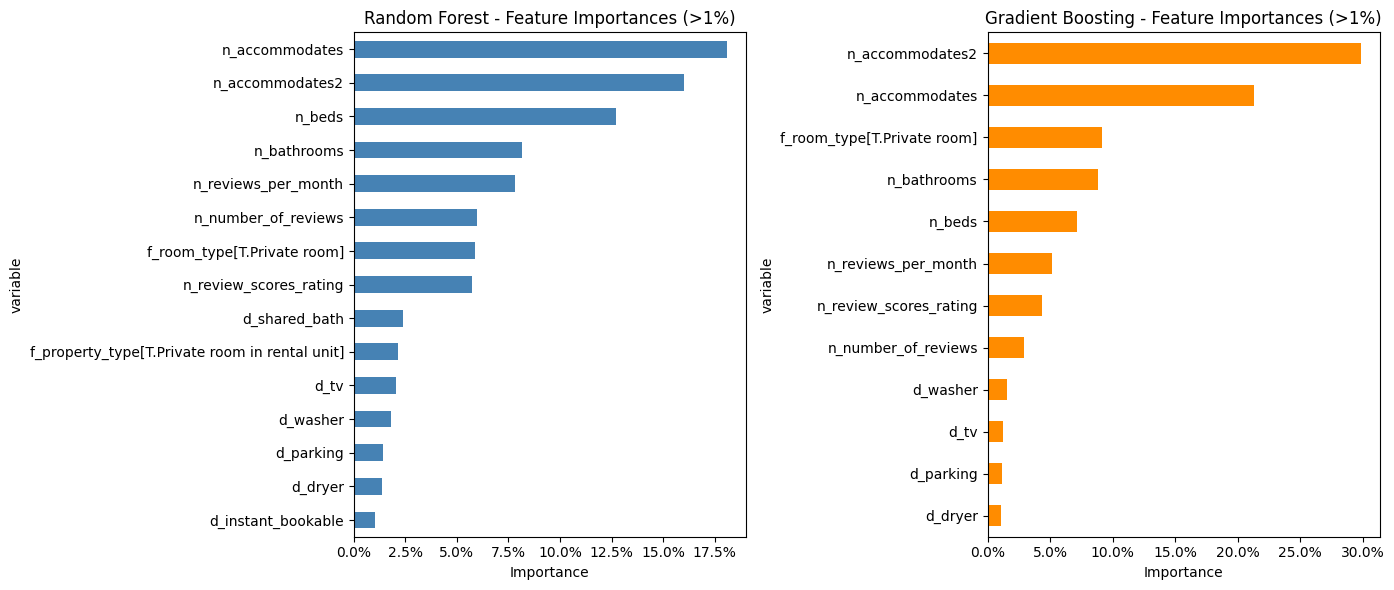

In [29]:
# =====================================================
# Plot feature importance (following class-16 pattern)
# Only show variables with importance > 1%
# =====================================================

cutoff = 0.01

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest (left)
ax1 = df_rf_var_imp[df_rf_var_imp.imp > cutoff]\
    .sort_values(by='imp')\
    .plot(kind='barh', x='variable', y='imp', 
          ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Random Forest - Feature Importances (>1%)')
axes[0].set_xlabel('Importance')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Gradient Boosting (right)
ax2 = df_gb_var_imp[df_gb_var_imp.imp > cutoff]\
    .sort_values(by='imp')\
    .plot(kind='barh', x='variable', y='imp', 
          ax=axes[1], legend=False, color='darkorange')
axes[1].set_title('Gradient Boosting - Feature Importances (>1%)')
axes[1].set_xlabel('Importance')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [30]:
# =====================================================
# Compare top 10 features between RF and GB
# =====================================================

rf_top10 = set(df_rf_var_imp.head(10)['variable'])
gb_top10 = set(df_gb_var_imp.head(10)['variable'])

overlap = rf_top10.intersection(gb_top10)
rf_only = rf_top10 - gb_top10
gb_only = gb_top10 - rf_top10

print("=" * 60)
print("FEATURE IMPORTANCE COMPARISON: Top 10 Features")
print("=" * 60)
print(f"\nFeatures in BOTH top 10 ({len(overlap)}):")
for f in sorted(overlap):
    print(f"  - {f}")

print(f"\nRandom Forest only ({len(rf_only)}):")
for f in sorted(rf_only):
    print(f"  - {f}")

print(f"\nGradient Boosting only ({len(gb_only)}):")
for f in sorted(gb_only):
    print(f"  - {f}")

FEATURE IMPORTANCE COMPARISON: Top 10 Features

Features in BOTH top 10 (8):
  - f_room_type[T.Private room]
  - n_accommodates
  - n_accommodates2
  - n_bathrooms
  - n_beds
  - n_number_of_reviews
  - n_review_scores_rating
  - n_reviews_per_month

Random Forest only (2):
  - d_shared_bath
  - f_property_type[T.Private room in rental unit]

Gradient Boosting only (2):
  - d_tv
  - d_washer


### Discussion: Feature Importance

**What's driving prices?**

No surprises here — both RF and GB agree that **capacity** (accommodates, beds, bathrooms) dominates. The squared accommodates term ranks high too, which confirms that pricing isn't linear in capacity. Going from 2→4 guests probably adds more value than 6→8.

**Room type matters a lot.** Private rooms are priced very differently from entire homes, which makes sense. Nobody expects to pay full-apartment prices for a room in someone's house.

**Review metrics show up** but aren't the top drivers. I think this is because reviews proxy for quality, but capacity proxies for what you're actually getting. A 5-star closet is still a closet.

**Amenities are less important than I expected.** Washer, dryer, TV — they matter, but they're not game-changers. Maybe because most Copenhagen/Oslo listings already have basic amenities? In a market with more variance (budget hostels vs luxury villas), amenities might matter more.

## Part II: Task 5 & 6 - External Validation Summary

The external validation results are already incorporated in the horserace table above.

### Key Findings:

**Temporal Validation (Copenhagen Sept 2025):**
- This is a real 6-month time gap from the training data (March → September)
- Performance here tells us if the model captures durable pricing patterns or just memorized a snapshot
- Seasonal effects matter: September might have different tourism patterns than March

**Spatial Validation (Oslo Sept 2025):**
- Same time period as temporal test, but different market
- This isolates the "location effect" — if spatial is worse than temporal, it's geography causing the gap, not time

**Comparing temporal vs spatial:**

This setup is nice because we can actually separate time and location effects:
- If temporal >> spatial: the model struggles with new locations more than new time periods
- If temporal ≈ spatial: both forms of generalization are similarly challenging
- If temporal << spatial: time drift hurts more than location shift (would be surprising)

My expectation: spatial validation will be harder because Oslo and Copenhagen, while both Nordic capitals, have different neighborhood structures, price levels, and currency (NOK vs DKK). The model was never trained on Oslo-specific features.

In [31]:
# =====================================================
# FINAL SUMMARY
# =====================================================

print("=" * 80)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 80)
print(f"\nTraining data: Copenhagen March 2025 ({len(df_train):,} observations)")
print(f"Temporal validation: Copenhagen Sept 2025 ({len(df_temporal):,} observations)")
print(f"Spatial validation: Oslo Sept 2025 ({len(df_spatial):,} observations)")
print(f"\nNumber of features: {X_train.shape[1]}")
print(f"Target variable: price (in local currency)")
print("\n")
print(results_df.to_string(index=False))

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)
print("""
1. TRAINING PERFORMANCE:
   - Tree-based models (RF, GB) typically achieve lower training RMSE
   - This reflects their higher flexibility/capacity

2. TEMPORAL GENERALIZATION (Copenhagen March → Sept):
   - Tests if pricing patterns persist across 6 months
   - Seasonal effects and market changes between Q1 and Q3

3. SPATIAL GENERALIZATION (Copenhagen → Oslo):
   - Tests if pricing patterns transfer across cities
   - Both are Nordic capitals but different markets/currencies

4. MODEL SELECTION:
   - If interpretability matters: OLS, LASSO, or Ridge
   - If prediction accuracy matters: Random Forest or Gradient Boosting
   - Best overall: Consider the model with best holdout performance
""")

FINAL MODEL COMPARISON SUMMARY

Training data: Copenhagen March 2025 (12,250 observations)
Temporal validation: Copenhagen Sept 2025 (12,788 observations)
Spatial validation: Oslo Sept 2025 (8,197 observations)

Number of features: 60
Target variable: price (in local currency)


            Model  Train_RMSE  Train_R2  Temporal_RMSE  Temporal_R2  Spatial_RMSE  Spatial_R2  Train_Time  Inference_Time
              OLS  458.219156  0.339053     547.026410     0.265232    647.421078    0.289277    0.305996        0.213060
            LASSO  459.648805  0.334922     548.414632     0.261498    652.183364    0.278783    0.361002        0.048353
    Random Forest  402.376310  0.490335     530.888920     0.307944    652.810261    0.277396   19.240500        0.303014
Gradient Boosting  428.662111  0.421570     538.998157     0.286641    652.256749    0.278621   46.076135        0.136555
            Ridge  458.769357  0.337465     547.496928     0.263967    649.125397    0.285530    2.810589     

In [32]:
# Save results to CSV
results_df.to_csv('model_results.csv', index=False)
print("Results saved to model_results.csv")

Results saved to model_results.csv


---

## AI Declaration

This assignment was completed with assistance from AI tools (GitHub Copilot and Gemini CLI) in accordance with the course AI policy.

**What AI was used for:**
- Writing and debugging Python code (data preprocessing, model fitting, evaluation loops)
- Code refactoring to match course material patterns (variable naming conventions like `n_`, `f_`, `d_` prefixes)
- Generating boilerplate code for visualization and model comparison tables
- Fixing errors (e.g., the categorical variable mismatch with patsy that required harmonizing category levels)

**What I did myself:**
- Deciding on the analysis strategy and interpreting results
- Choosing which models to compare and why (e.g., Ridge as the 5th model to complement LASSO)
- Writing the discussion sections and explaining decision points
- Verifying all code outputs make sense and checking the logic

**Responsibility:**
I reviewed all AI-generated code and take full responsibility for the final submission. Any errors in the analysis or interpretation are mine.